
# # Stock Price Prediction Model
# 
# This notebook downloads historical stock data using `yfinance`, engineers technical indicators, trains both short‑term and long‑term models using deep learning (LSTM/GRU), saves the trained models and scalers, and visualizes training performance metrics such as loss and mean absolute error (MAE) to assess model accuracy and precision.


In [29]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import os
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.src.optimizers import Adam
from keras.src.regularizers import L2
from keras.src.models import Sequential
from keras.src.layers import LSTM, Dense, Dropout, BatchNormalization, GRU
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.src.losses import Huber



# ## 1. Data Acquisition and Preprocessing
# 
# The function below downloads the data and creates several technical indicators.


In [30]:


def get_enhanced_stock_data(ticker, period='1y'):
    """Download and prepare enhanced stock data"""
    try:
        stock = yf.Ticker(ticker)
        df = stock.history(period=period)
        
        if df.empty:
            return None
        
        # Basic features
        df['Daily_Return'] = df['Close'].pct_change()
        df['Daily_Range'] = df['High'] - df['Low']
        df['Range_Pct'] = df['Daily_Range'] / df['Open']
        
        # Moving Averages
        for window in [5, 10, 20, 50, 100, 200]:
            df[f'MA{window}'] = df['Close'].rolling(window=window).mean()
            
        # Moving average crossovers
        df['MA_5_20_Cross'] = df['MA5'] - df['MA20']
        df['MA_20_50_Cross'] = df['MA20'] - df['MA50']
        
        # Exponential moving averages
        for window in [12, 26]:
            df[f'EMA{window}'] = df['Close'].ewm(span=window, adjust=False).mean()
        
        # RSI
        for window in [14, 28]:
            delta = df['Close'].diff()
            gain = delta.where(delta > 0, 0).rolling(window=window).mean()
            loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
            rs = gain / loss
            df[f'RSI{window}'] = 100 - (100 / (1 + rs))
        
        # MACD
        df['MACD'] = df['EMA12'] - df['EMA26']
        df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['MACD_hist'] = df['MACD'] - df['MACD_signal']
        
        # Bollinger Bands
        for window in [20]:
            df[f'BB_middle{window}'] = df['Close'].rolling(window=window).mean()
            df[f'BB_std{window}'] = df['Close'].rolling(window=window).std()
            df[f'BB_upper{window}'] = df[f'BB_middle{window}'] + 2 * df[f'BB_std{window}']
            df[f'BB_lower{window}'] = df[f'BB_middle{window}'] - 2 * df[f'BB_std{window}']
            df[f'BB_width{window}'] = (df[f'BB_upper{window}'] - df[f'BB_lower{window}']) / df[f'BB_middle{window}']
        
        # Volatility
        for window in [10, 21]:
            df[f'Volatility{window}'] = df['Daily_Return'].rolling(window=window).std()
        
        # Volume indicators
        df['Volume_Change'] = df['Volume'].pct_change()
        for window in [5, 10, 20]:
            df[f'Volume_MA{window}'] = df['Volume'].rolling(window=window).mean()
            df[f'Volume_Ratio{window}'] = df['Volume'] / df[f'Volume_MA{window}']
        
        # Momentum
        for window in [5, 10, 21]:
            df[f'Momentum{window}'] = df['Close'] / df['Close'].shift(window) - 1
        
        # Price to Moving Average ratios
        df['Price_to_MA20'] = df['Close'] / df['MA20']
        df['Price_to_MA50'] = df['Close'] / df['MA50']
        
        df = df.dropna()
        return df
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None


# ## 2. Feature Selection and Data Preparation
# 
# The following functions select optimal features based on correlation analysis and prepare sequences for model training.



In [31]:

def select_optimal_features(df, target_col='Close', correlation_threshold=0.3):
    """Select optimal features based on correlation analysis and domain knowledge"""
    # Calculate correlation with target
    correlation_with_target = df.corr()[target_col].abs().sort_values(ascending=False)
    
    # Select features with correlation above threshold
    strong_features = correlation_with_target[correlation_with_target > correlation_threshold].index.tolist()
    
    # Ensure we include these important technical indicators regardless of correlation
    essential_features = ['RSI14', 'MACD', 'Volatility21', 'Volume_Ratio20', 'BB_width20']
    
    for feature in essential_features:
        if feature in df.columns and feature not in strong_features:
            strong_features.append(feature)
    
    # Remove highly correlated features
    features_to_use = []
    correlation_matrix = df[strong_features].corr().abs()
    for feature in strong_features:
        if feature not in features_to_use:
            correlated_features = correlation_matrix.index[correlation_matrix[feature] > 0.9].tolist()
            if feature == target_col or feature not in [f for f in correlated_features if f != feature and f in features_to_use]:
                features_to_use.append(feature)
    return features_to_use

def create_sequences(data, seq_length):
    """Create sequences of data for time series prediction"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # use all columns except the last (target)
        y.append(data[i+seq_length-1, -1])   # target is the last column of the last row in sequence
    return np.array(X), np.array(y).reshape(-1, 1)

def prepare_data_for_models(df, target_col='Close', short_term_seq=20, long_term_seq=60):
    """Prepare data for both short-term and long-term models with advanced preprocessing"""
    # Select optimal features
    optimal_features = select_optimal_features(df, target_col)
    if target_col not in optimal_features:
        optimal_features.append(target_col)
        
    feature_df = df[optimal_features].copy()
    feature_df = feature_df.fillna(method='ffill').fillna(method='bfill')
    
    # Scale features
    feature_columns = [col for col in optimal_features if col != target_col]
    feature_scaler = RobustScaler()
    target_scaler = MinMaxScaler()
    
    # Scale target separately
    target_values = df[target_col].values.reshape(-1, 1)
    target_scaled = target_scaler.fit_transform(target_values)
    
    feature_values = feature_df[feature_columns].values
    features_scaled = feature_scaler.fit_transform(feature_values)
    
    # Combine scaled features and target into one dataset
    scaled_data = np.column_stack((features_scaled, target_scaled))
    
    # Create sequences for short-term and long-term models
    X_short, y_short = create_sequences(scaled_data, short_term_seq)
    X_long, y_long = create_sequences(scaled_data, long_term_seq)
    
    return {
        'short_term': {
            'X': X_short,
            'y': y_short,
            'feature_scaler': feature_scaler,
            'target_scaler': target_scaler,
            'features': feature_columns
        },
        'long_term': {
            'X': X_long,
            'y': y_long,
            'feature_scaler': feature_scaler,
            'target_scaler': target_scaler,
            'features': feature_columns
        },
        'optimal_features': optimal_features
    }




# ## 3. Model Building
# 
# Two functions create the short-term and long-term models respectively. Regularization, dropout, and callbacks are used to improve training robustness.



In [32]:

def build_short_term_model(input_shape, dropout_rate=0.3):
    """Build an improved LSTM model for short-term predictions"""
    from keras.src.layers import Bidirectional
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(64, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=Huber(),
        metrics=['mae']
    )
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
    ]
    return model, callbacks

def build_long_term_model(input_shape, dropout_rate=0.4):
    """Build an improved model for long-term predictions with regularization"""
    model = Sequential()
    model.add(GRU(96, return_sequences=True, 
                  kernel_regularizer=L2(1e-4), 
                  recurrent_regularizer=L2(1e-4),
                  input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(64, return_sequences=False, kernel_regularizer=L2(1e-4)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(32, activation='relu', kernel_regularizer=L2(1e-3)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mae',
        metrics=['mse', 'mae']
    )
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=5e-6)
    ]
    return model, callbacks



# ## 4. Training and Saving Models
# 
# This function trains both models and saves the trained models, scalers, and training history.



In [33]:

def train_and_save_models(ticker, period='5y'):
    # Get data
    df = get_enhanced_stock_data(ticker, period=period)
    if df is None or len(df) < 200:
        return False, "Insufficient data for training models"
    
    data_dict = prepare_data_for_models(df)
    
    # Build models
    short_term_model, short_callbacks = build_short_term_model(
        input_shape=(data_dict['short_term']['X'].shape[1], data_dict['short_term']['X'].shape[2])
    )
    long_term_model, long_callbacks = build_long_term_model(
        input_shape=(data_dict['long_term']['X'].shape[1], data_dict['long_term']['X'].shape[2])
    )
    
    # Train models
    print("Training short-term model...")
    short_history = short_term_model.fit(
        data_dict['short_term']['X'], data_dict['short_term']['y'],
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=short_callbacks,
        verbose=1
    )
    
    print("Training long-term model...")
    long_history = long_term_model.fit(
        data_dict['long_term']['X'], data_dict['long_term']['y'],
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=long_callbacks,
        verbose=1
    )
    
    # Create directory to save models
    models_dir = f"models/{ticker}"
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    
    # Save models
    short_term_model.save(f"{models_dir}/short_term_model.keras")
    long_term_model.save(f"{models_dir}/long_term_model.keras")
    
    # Save scalers and feature lists
    joblib.dump(data_dict['short_term']['feature_scaler'], f"{models_dir}/short_term_feature_scaler.pkl")
    joblib.dump(data_dict['short_term']['target_scaler'], f"{models_dir}/short_term_target_scaler.pkl")
    joblib.dump(data_dict['long_term']['feature_scaler'], f"{models_dir}/long_term_feature_scaler.pkl")
    joblib.dump(data_dict['long_term']['target_scaler'], f"{models_dir}/long_term_target_scaler.pkl")
    
    with open(f"{models_dir}/short_term_features.txt", "w") as f:
        f.write(",".join(data_dict['short_term']['features']))
    with open(f"{models_dir}/long_term_features.txt", "w") as f:
        f.write(",".join(data_dict['long_term']['features']))
    
    # Save training history
    joblib.dump(short_history.history, f"{models_dir}/short_term_history.pkl")
    joblib.dump(long_history.history, f"{models_dir}/long_term_history.pkl")
    
    with open(f"{models_dir}/last_trained.txt", "w") as f:
        f.write(str(datetime.datetime.now()))
    
    return True, "Models trained and saved successfully"


In [34]:

from keras.models import load_model

def load_models(ticker):
    models_dir = f"models/{ticker}"
    if not os.path.exists(models_dir):
        return None, f"No trained models found for {ticker}. Please train models first."
    try:
        # Use Keras load_model for models
        short_term_model = load_model(f"{models_dir}/short_term_model.keras")
        long_term_model = load_model(f"{models_dir}/long_term_model.keras")
        
        # Use joblib for scalers, history, etc.
        short_term_feature_scaler = joblib.load(f"{models_dir}/short_term_feature_scaler.pkl")
        short_term_target_scaler = joblib.load(f"{models_dir}/short_term_target_scaler.pkl")
        long_term_feature_scaler = joblib.load(f"{models_dir}/long_term_feature_scaler.pkl")
        long_term_target_scaler = joblib.load(f"{models_dir}/long_term_target_scaler.pkl")
        
        with open(f"{models_dir}/short_term_features.txt", "r") as f:
            short_term_features = f.read().split(",")
        with open(f"{models_dir}/long_term_features.txt", "r") as f:
            long_term_features = f.read().split(",")
            
        short_term_history = joblib.load(f"{models_dir}/short_term_history.pkl")
        long_term_history = joblib.load(f"{models_dir}/long_term_history.pkl")
        
        with open(f"{models_dir}/last_trained.txt", "r") as f:
            last_trained = f.read()
            
        return {
            'short_term': {
                'model': short_term_model,
                'feature_scaler': short_term_feature_scaler,
                'target_scaler': short_term_target_scaler,
                'features': short_term_features,
                'history': short_term_history
            },
            'long_term': {
                'model': long_term_model,
                'feature_scaler': long_term_feature_scaler,
                'target_scaler': long_term_target_scaler,
                'features': long_term_features,
                'history': long_term_history
            },
            'last_trained': last_trained
        }, None
    except Exception as e:
        return None, f"Error loading models: {str(e)}"




# ## 6. Making Predictions
# 
# This function loads the models and makes future predictions for a specified number of days.
# (Note: The prediction update for each day is implemented in a simplified manner.)



In [35]:

def prepare_data_for_advanced_prediction(df, features, seq_length, scaler):
    """Prepare the latest data for advanced model prediction"""
    if len(df) < seq_length:
        return None
    selected_df = df[features].copy().fillna(method='ffill')
    recent_data = selected_df.tail(seq_length).values
    scaled_data = scaler.transform(recent_data)
    X = np.array([scaled_data])
    return X

def make_predictions(ticker, prediction_days=30, model_type='both'):
    models_dict, error = load_models(ticker)
    if error:
        return None, error
    
    df = get_enhanced_stock_data(ticker, period='1y')
    if df is None:
        return None, f"Could not fetch recent data for {ticker}"
    
    prediction_results = {
        'dates': [(df.index[-1] + pd.Timedelta(days=i+1)).date() for i in range(prediction_days)],
        'last_price': df['Close'].iloc[-1],
        'last_date': df.index[-1].date()
    }
    
    if model_type in ['short_term', 'both']:
        try:
            short_term_X = prepare_data_for_advanced_prediction(
                df, 
                models_dict['short_term']['features'], 
                len(models_dict['short_term']['features']), 
                models_dict['short_term']['feature_scaler']
            )
            short_term_preds = []
            last_pred_point = short_term_X
            for i in range(prediction_days):
                pred_scaled = models_dict['short_term']['model'].predict(last_pred_point, verbose=0)
                pred_value = models_dict['short_term']['target_scaler'].inverse_transform(pred_scaled)[0][0]
                short_term_preds.append(pred_value)
                # Simple update: roll the sequence and update with the new prediction
                new_row = last_pred_point[0, -1:].copy()
                new_row[0, -1] = pred_value
                last_pred_point = np.roll(last_pred_point, -1, axis=1)
                last_pred_point[0, -1] = new_row
            prediction_results['short_term'] = short_term_preds
        except Exception as e:
            prediction_results['short_term_error'] = str(e)
    
    if model_type in ['long_term', 'both']:
        try:
            long_term_X = prepare_data_for_advanced_prediction(
                df, 
                models_dict['long_term']['features'], 
                len(models_dict['long_term']['features']), 
                models_dict['long_term']['feature_scaler']
            )
            long_term_preds = []
            last_pred_point = long_term_X
            for i in range(prediction_days):
                pred_scaled = models_dict['long_term']['model'].predict(last_pred_point, verbose=0)
                pred_value = models_dict['long_term']['target_scaler'].inverse_transform(pred_scaled)[0][0]
                long_term_preds.append(pred_value)
                new_row = last_pred_point[0, -1:].copy()
                new_row[0, -1] = pred_value
                last_pred_point = np.roll(last_pred_point, -1, axis=1)
                last_pred_point[0, -1] = new_row
            prediction_results['long_term'] = long_term_preds
        except Exception as e:
            prediction_results['long_term_error'] = str(e)
    
    if model_type == 'both' and 'short_term' in prediction_results and 'long_term' in prediction_results:
        ensemble_preds = []
        for i in range(prediction_days):
            short_weight = max(0.2, 1.0 - i/prediction_days)
            long_weight = 1.0 - short_weight
            ensemble_value = (prediction_results['short_term'][i] * short_weight +
                              prediction_results['long_term'][i] * long_weight)
            ensemble_preds.append(ensemble_value)
        prediction_results['ensemble'] = ensemble_preds
    
    return prediction_results, None




# ## 7. Visualization of Training Performance (Accuracy and Precision)
# 
# For regression tasks, we visualize loss and mean absolute error (MAE) as indicators of model performance.
# These plots serve as proxies for accuracy (how close predictions are to actual values) and precision (consistency in error).




In [36]:

def plot_training_history(history, title="Model Training History"):
    """Plot training and validation loss and MAE from a model's history."""
    history = pd.DataFrame(history)
    epochs = range(1, len(history)+1)
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    ax1.plot(epochs, history['loss'], label='Training Loss', color='blue')
    if 'val_loss' in history.columns:
        ax1.plot(epochs, history['val_loss'], label='Validation Loss', color='orange')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    if 'mae' in history.columns:
        ax2.plot(epochs, history['mae'], label='Training MAE', color='green')
    if 'val_mae' in history.columns:
        ax2.plot(epochs, history['val_mae'], label='Validation MAE', color='red')
    ax2.set_ylabel('MAE', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    
    plt.title(title)
    plt.tight_layout()
    plt.show()


# ## 8. Main Execution Section
# 
# Here you can specify a ticker symbol, train models (if needed), and visualize both predictions and training performance.

Training short-term model...
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 0.5375 - mae: 0.9258 - val_loss: 0.1655 - val_mae: 0.5642 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.2148 - mae: 0.5226 - val_loss: 0.1757 - val_mae: 0.5771 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1888 - mae: 0.4967 - val_loss: 0.1625 - val_mae: 0.5548 - learning_rate: 0.0010
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1613 - mae: 0.4581 - val_loss: 0.0739 - val_mae: 0.3695 - learning_rate: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1278 - mae: 0.3980 - val_loss: 0.0746 - val_mae: 0.3719 - learning_rate: 0.0010
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1151 - mae: 0.3767 - val_loss: 0.0578 - val_mae: 0.3237 - learning_rate: 0.0010
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0939 - mae: 0.3395 - val_loss: 0.0724 - val_mae: 0.3610 -

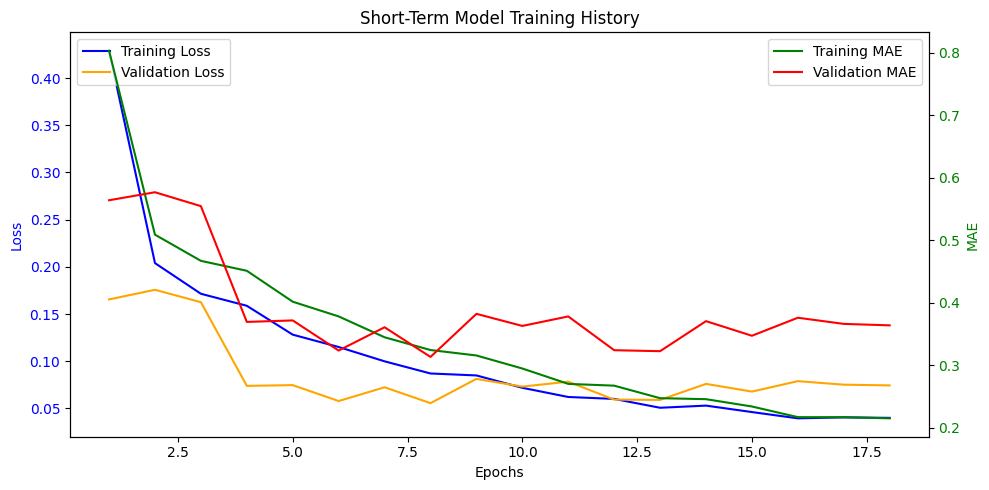


Long-Term Model Training History:


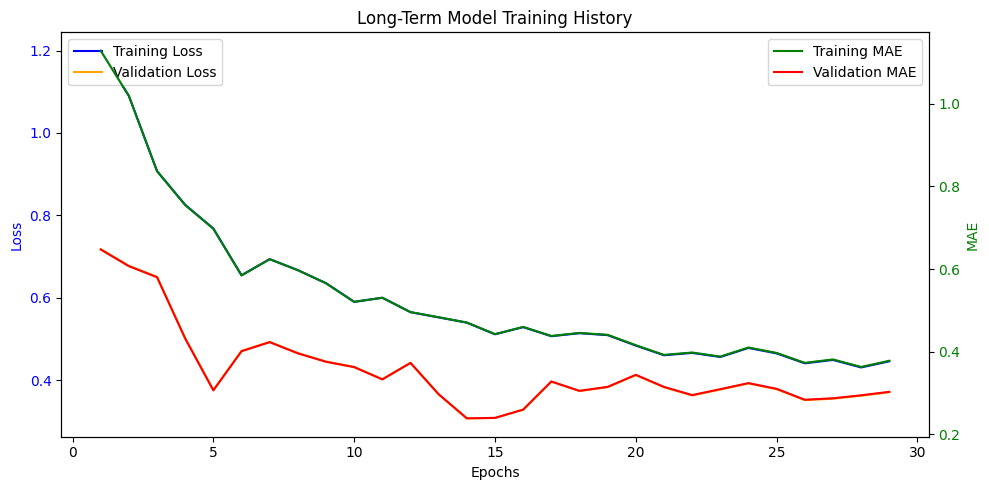

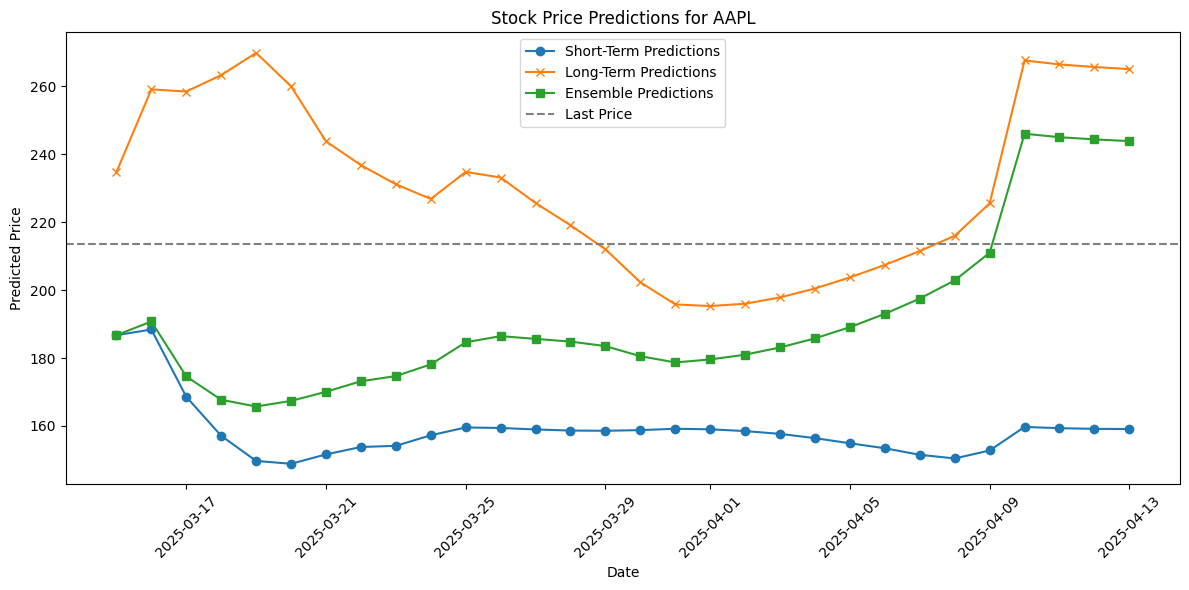

In [37]:

# Specify a ticker symbol (e.g., "AAPL")
ticker = "AAPL"

# Uncomment the next line to train and save models if they are not trained yet.
success, message = train_and_save_models(ticker, period='5y')
print(message)

# Load the models and get training history for visualization
models_dict, error = load_models(ticker)
if error:
    print(error)
else:
    print(f"Models last trained on: {models_dict['last_trained']}")
    
    # Visualize short-term training history
    print("\nShort-Term Model Training History:")
    plot_training_history(models_dict['short_term']['history'], title="Short-Term Model Training History")
    
    # Visualize long-term training history
    print("\nLong-Term Model Training History:")
    plot_training_history(models_dict['long_term']['history'], title="Long-Term Model Training History")

# %%
# Make predictions for the next 30 days and plot them
pred_results, error = make_predictions(ticker, prediction_days=30, model_type='both')
if error:
    print(error)
else:
    dates = pred_results['dates']
    plt.figure(figsize=(12, 6))
    plt.plot(dates, pred_results['short_term'], label="Short-Term Predictions", marker='o')
    plt.plot(dates, pred_results['long_term'], label="Long-Term Predictions", marker='x')
    if 'ensemble' in pred_results:
        plt.plot(dates, pred_results['ensemble'], label="Ensemble Predictions", marker='s')
    plt.axhline(pred_results['last_price'], color='gray', linestyle='--', label="Last Price")
    plt.xlabel("Date")
    plt.ylabel("Predicted Price")
    plt.title(f"Stock Price Predictions for {ticker}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [1]:
import subprocess

def generate_requirements():
    subprocess.run(['pipreqs', '.'])

generate_requirements()
